### Carregando as Bibliotecas

In [1]:
! pip install lightgbm
! pip install xgboost

In [2]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [4]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

In [5]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Arquivo_EUA

In [6]:
X= pd.read_excel(r'X.xlsx')

In [7]:
output= pd.read_excel(r'yhyd.xlsx', header=0)

In [8]:
X =X.fillna(0.001)

In [9]:
X.head(2)

pibe_capita  pibe_areae  pope_areae  pibe_GWe   GWe_pope
0     0.046529    1.739276   37.380099  0.001599  29.099337
1     0.074343    0.113787    1.530579  0.008958   8.298660

### Normalização dados entrada_EUA

In [10]:
#Normalização dos dados de entrada -- variável explicativa
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ent = scaler.fit_transform(X) # dados X: normalizados

### Hidrica

In [11]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(ent,output,test_size =0.3, random_state=1234)

In [12]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

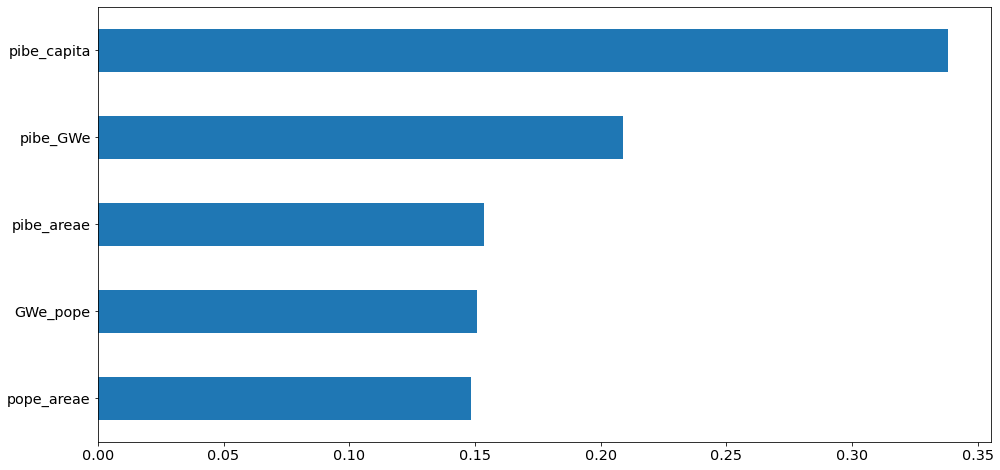

In [13]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10).sort_values().plot.barh())

### Algoritmo Referência = Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [15]:
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10,11,12],
              "max_features":['auto'],
              'max_depth':[5,10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 660 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    9.5s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [16]:
random_rf.best_params_

{'n_estimators': 2,
 'min_samples_split': 3,
 'min_samples_leaf': 10,
 'max_leaf_nodes': 2,
 'max_features': 'auto',
 'max_depth': 10}

In [17]:
m_rf=RandomForestRegressor(n_estimators= 2,
 min_samples_split = 3,
 min_samples_leaf = 10,
 max_leaf_nodes = 2,
 max_features ='auto',
 max_depth = 10)

In [18]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=2,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=3,
                      min_weight_fraction_leaf=0.0, n_estimators=2, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [19]:
y_rf= yrf.predict(X_test)

### Avaliação dos Erros

In [21]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error # MSE
# RMSE = mean_squared_error(y_test,y_pred,squared=False) 
from sklearn.metrics import mean_absolute_error
import numpy as np
# MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
from sklearn.metrics import mean_squared_log_error

In [22]:
c=np.mean(y_train)
print(round(c,3))

hyde    4924.293
dtype: float64


In [23]:
R2 = r2_score(y_test,y_rf)
mse_rf = mean_squared_error(y_test, y_rf)
rmse_rf = mse_rf**0.5
mae_rf =  mean_absolute_error(y_test, y_rf)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_rf,3))
print('RMSE =', round(rmse_rf,3))
print('MAE = ', round(mae_rf,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.147
MSE = 70015255.433
RMSE = 8367.512
MAE =  5215.893


In [24]:
# R2 ajustado -- ponderação entre os fatores mais relevantes
def adjusted_r2(y_test, y_rf,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_rf)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
a= round(adjusted_r2(y_test,y_rf,X_train),3)
print(a)

-0.784


In [25]:
y_test=np.array(y_test)

In [26]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-125.9
221.8


In [27]:
a=np.mean(y_train) #teste média y_train
a
a = [a]*len(y_test)

In [28]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_rf = mse_rf/mse_m
print(round(mse_m,3), round(mse_rf,3))
print(round(r_rf,3))

61764058.023 70015255.433
1.134


### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [29]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [30]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [31]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [32]:
# GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(X_train, y_train)
 # XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(X_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(X_train, y_train)

print('*****************ClassifiersDone*****************')

*****************ClassifiersDone*****************


In [33]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [34]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.1s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.1s


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits

[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[19:04:37] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, learning rate, max depth, max_delta_step, max_depth, min_child_weight, min_child_weigth, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    6.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    8.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [35]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,output,cv=10)
score_lgb=cross_val_score(lgb,X,output,cv=10)
score_xgb=cross_val_score(xgb,X,output,cv=10)
score_ada=cross_val_score(ada,X,output,cv=10)

### Gradient Boosting

In [36]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.4, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.8, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [37]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth= 8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [38]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.15, loss='ls', max_depth=8,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=40, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [39]:
y_gbr = m_gbr.predict(X_test)

In [40]:
mse_gbr = round(mean_squared_error(y_test, y_gbr),3)
print(mse_gbr)

61899319.767


In [41]:
errop2= (y_test - y_gbr)*100/y_test
a = np.mean(errop2)
print(round(a,3))
# em porcentagem

-175.086


In [42]:
R2 = r2_score(y_test,y_gbr)
mse_gbr = mean_squared_error(y_test, y_gbr)
rmse_gbr = mse_gbr**0.5
mae_gbr =  mean_absolute_error(y_test, y_gbr)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_gbr,3))
print('RMSE =', round(rmse_gbr,3))
print('MAE = ', round(mae_gbr,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.014
MSE = 61899319.767
RMSE = 7867.612
MAE =  4927.256


In [43]:
def adjusted_r2(y_test, y_gbr,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_gbr)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
c = round(adjusted_r2(y_test,y_gbr,X_train),3)
print(c)

-0.577


In [44]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_gbr = mse_gbr/mse_m
print(round(mse_m,3), round(mse_gbr,3))
print(round(r_gbr,3))

61764058.023 61899319.767
1.002


### Light Gradient Boosting

In [45]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6, gamma=0.2, importance_type='split',
              learning rate=0.5, learning_rate=0.001, max depth=11,
              max_depth=-1, min_child_samples=20, min_child_weight=0.001,
              min_child_weigth=7, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)


In [46]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6, gamma=0.2, importance_type='split',
              learning_rate=0.4, max_depth=11,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [47]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(booster='gblinear', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.6, gamma=0.2, importance_type='split',
              learning_rate=0.4, max_depth=11, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [48]:
y_lgb = m_lgb.predict(X_test)

In [49]:
mse_lgb = round(mean_squared_error(y_test, y_lgb),3)
print(mse_lgb)

61764058.034


In [50]:
errop2= (y_test - y_lgb)*100/y_test
# em porcentagem

In [51]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_lgb = mse_lgb/mse_m
print(round(mse_m,3), round(mse_lgb,3))
print(round(r_lgb,3))

61764058.023 61764058.034
1.0


### XGBoosting

In [52]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.1, learning_rate=0.001, max depth=3,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [77]:
from xgboost import XGBRegressor
m_xgb_1= XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4,
             max_delta_step=0, max_depth=2, min_child_weight=3,
             missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [78]:
m_xgb_1.fit(X_train,y_train)

[19:07:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.4, max_delta_step=0, max_depth=2,
             min_child_weight=3, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [79]:
y_xgb_1= m_xgb_1.predict(X_test)

In [80]:
mse_xgb_1 = round(mean_squared_error(y_test, y_xgb_1),3)
print (mse_xgb_1)

61163884.036


In [81]:
errop2= (y_test - y_xgb_1)*100/y_test
# em porcentagem

In [82]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_xgb_1 = mse_xgb_1/mse_m
print(round(mse_m,3), round(mse_xgb_1,3))
print(round(r_xgb_1,3))

61764058.023 61163884.036
0.99


### Adaptative Boosting

In [83]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.01, loss='linear', n_estimators=50,
                  random_

In [84]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_state=None)

In [85]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_

In [86]:
y_ada = m_ada.predict(X_test)

In [87]:
mse_ada = round(mean_squared_error(y_test, y_ada),8)
print (mse_ada)

64026658.36908912


In [88]:
errop2= (y_test - y_ada)*100/y_test
# em porcentagem

In [89]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_ada = mse_ada/mse_m
print(round(mse_m,3), round(mse_ada,3))
print(round(r_ada,3))

61764058.023 64026658.369
1.037


In [90]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb_1,mse_ada]
pd.DataFrame(list(zip(mse)), columns =['Mean Square Error'], index=models)

Mean Square Error
Random_Forest       7.001526e+07
GradientBoost       6.189932e+07
LightGBM            6.176406e+07
XGBoost_1           6.116388e+07
AdaBoost            6.402666e+07

In [91]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost_1','AdaBoost']
r=[r_rf,r_gbr,r_lgb,r_xgb_1,r_ada]
pd.DataFrame(list(zip(r)), columns =['Razão_modelo_simples'], index=models)

Razão_modelo_simples
Random_Forest              1.133592
GradientBoost              1.002190
LightGBM                   1.000000
XGBoost_1                  0.990283
AdaBoost                   1.036633

### Predição dados Brasil

### Composição do arquivo de saída¶

In [92]:
entb= pd.read_excel(r'Xb.xlsx', header=0)
entb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 5 columns):
pibe_capita    26 non-null float64
pibe_area      26 non-null float64
pibe_GWe       26 non-null float64
pope_areae     26 non-null float64
GWe_pope       26 non-null float64
dtypes: float64(5)
memory usage: 1.1 KB


In [93]:
#Normalização dos dados de entrada -- variável explicativa
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
entb= scaler.fit_transform(entb) # dados X: normalizados

In [94]:
outputb= m_xgb_1.predict(entb)

In [95]:
outb=pd.DataFrame(data=outputb, columns=['Prev'])
outb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
Prev    26 non-null float32
dtypes: float32(1)
memory usage: 232.0 bytes


In [96]:
br= pd.read_excel(r'br_estado.xlsx', header=0)

In [97]:
br=br.drop(columns=['PIB em 2017 (1.000.000 R$)','Área (km2)','Geração de energia GW.h','População'])
br.head(1)

Unidades da Federação
0                  Acre

In [98]:
br = br.rename({'Unidades da Federação': 'Estado'}, axis = 1)

In [99]:
br = pd.DataFrame(data=br)

In [100]:
br1 = pd.DataFrame(data=outputb, columns=["Previsão"])
br1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 1 columns):
Previsão    26 non-null float32
dtypes: float32(1)
memory usage: 232.0 bytes


In [101]:
prv = pd.concat([br, br1], axis=1, sort=False)

In [102]:
prv.head(30)

Estado     Previsão
0                  Acre  4673.760742
1               Alagoas  4909.027832
2                 Amapá  4968.690918
3              Amazonas  4967.523438
4                 Bahia  4940.209473
5                 Ceará  4915.787598
6        Espírito Santo  4825.825684
7                 Goiás  4994.008301
8              Maranhão  4934.539551
9           Mato Grosso  5047.751465
10   Mato Grosso do Sul  5034.850098
11         Minas Gerais  4962.900879
12               Paraná  5012.844238
13              Paraíba  4789.457031
14                 Pará  4967.556641
15           Pernambuco  4883.889160
16                Piauí  4943.605957
17       Rio de Janeiro  4754.835449
18  Rio Grande do Norte  4949.797363
19    Rio Grande do Sul  4999.601074
20             Rondônia  4945.942383
21              Roraima  4795.420898
22       Santa Catarina  4986.204590
23              Sergipe  4891.646973
24            São Paulo  4821.860352
25            Tocantins  4983.985840